# Sentiment analysis with RNN

In [1]:
import numpy as np
import scipy.sparse
import json
import zipfile

import spacy
from gensim import corpora
from gensim.models import tfidfmodel
from gensim.matutils import corpus2csc
from gensim.corpora.dictionary import Dictionary

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from collections import Counter, OrderedDict
from os.path import expanduser
import re, time
from sklearn.model_selection import train_test_split


import torch
import torch.nn.utils.rnn as rnn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from itertools import zip_longest
from operator import itemgetter

In [3]:
re_run = False
torch.cuda.get_device_name(0)

'GeForce GTX 1080'

# Importing

Data is preprocessed as a tuple of lists, reviews are parsed and stop words and punctuation are removed.

In [4]:
%%time

if re_run:
    # processed from gensim_walkthrough notebook
    with open('../../data/processed/processed.txt', 'r') as f:
        restaurants = {i:json.loads(line) for i, line in enumerate(f)}

    # different text cleaning for reviews
    with open('../../data/processed/reviews_cleaned.txt', 'r') as f:
        reviews = tuple(json.loads(line) for line in f)

CPU times: user 12.2 s, sys: 1.13 s, total: 13.3 s
Wall time: 13.4 s


In [5]:
def make_dict(line, adc):

        for item in line:
            if item in adc.keys():
                next
            else:
                adc[item] = len(adc)+1
        
def make_labels(lsls):
    now = time.time()
    adc={}
    
    for ls in lsls:
        make_dict(ls, adc=adc)
    print(time.time() - now)
    return adc

def tokenize(x): return re.findall('\w+', x)


In [6]:
from tqdm import tqdm, tqdm_notebook, tnrange

In [6]:
label_dc = {}
i=0
texts= []
idx = []

for ls in restaurants.values():
    
    
    if 'Restaurants' in ls['category']:
        try:
            idx.append(i), make_dict(ls['category'], adc=label_dc), texts.append(tokenize(ls['text'].lower()))
        except Exception as e:
            print(e, i)

    i +=1
    if i % 100000 == 0:
        print(f'{i} lines have completed there are currently {len(label_dc.keys())} keys')

100000 lines have completed there are currently 281 keys
200000 lines have completed there are currently 317 keys
300000 lines have completed there are currently 346 keys
400000 lines have completed there are currently 363 keys


In [7]:
%%time
vocab = make_labels(texts)

9.314396858215332
CPU times: user 9.31 s, sys: 657 µs, total: 9.31 s
Wall time: 9.31 s


In [8]:
#corpus = [[vocab[word] for word in line] for line in texts]

## Doing the same process with gensim

Skipping a step by not creating two dictionaries for train and test, they get recombined anyway for an update of new data though.

In [4]:
%%time

if re_run:
    
    # create dictionary
    dict_yelp = corpora.Dictionary(reviews)
    # tune corpus to get a smaller dictionary and therefore a smaller doc_term matrix, 
    # embeddings will still work but bow will not fit into 8gb gpu otherwise
    dict_yelp.filter_extremes(no_below=20, keep_n=13000)
    dict_yelp.save('../../data/processed/dictionary')

else:
    
    dict_yelp = corpora.Dictionary.load('../../data/processed/dictionary')

print(len(dict_yelp))

13000
CPU times: user 5.92 ms, sys: 298 µs, total: 6.22 ms
Wall time: 13.4 ms


In [6]:
if re_run:
    # most common words
    top_ids = sorted(dict_yelp.dfs.items(), key=lambda x: x[1], reverse=True)[0:30]
    [(dict_yelp[item[0]], item[1]) for item in top_ids]

In [269]:
# res = list(zip_longest(*corpus[0:5], fillvalue=0))
# res = embed(torch.tensor(res))
# res = rnn.pack_padded_sequence(res, torch.tensor([100]*5))

In [101]:
def text_sequencer(dictionary, text, max_len=200):
    
    processed = []
    # in case the word is not in the dictionary because it was filtered out use this number to represent an out of set id 
    dict_final = len(dictionary.keys()) + 1
    
    for i, word in enumerate(text):        
        if i > max_len-1:
            break
        if word in dictionary.token2id.keys():
    # remember the ids have an offset of 1 for this because 0 represents a padded value        
            processed.append(dictionary.token2id[word] + 1) 
        else:
            processed.append(dict_final)
    
    return processed

In [100]:
%%time
corpus = [text_sequencer(dict_yelp, review) for review in reviews]

CPU times: user 57.5 s, sys: 4.12 ms, total: 57.5 s
Wall time: 57.6 s


In [5]:
%%time

if re_run:
    
    corpus = [np.array(text_sequencer(dict_yelp, review)) for review in reviews]
    #corpus_ = prep_data(corpus)
    
    # this is the converted corpus array, not bow
    np.save('../../data/processed/corpus.npy', corpus)

else:
    
    corpus = np.load('../../data/processed/corpus.npy')

CPU times: user 2.07 s, sys: 435 ms, total: 2.51 s
Wall time: 2.54 s


In [13]:
def make_dataset(data, indices):
    ls=[]
    for idx in indices:
        ls.append(data[idx])
    return ls
    

## Integrating glove embeddings

In [7]:
def load_embeddings(emb_path = '/projects/embeddings/data/'):
    # load glove vectors
    embeddings_index={}
    with zipfile.ZipFile(expanduser("~")+ emb_path +'glove.6B.zip', 'r') as f:
        with f.open('glove.6B.100d.txt', 'r') as z:
            for line in z:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    
    return embeddings_index

def id_to_glove(dict_yelp):
    
    embeddings_index = load_embeddings()
    conversion_table = {}
    for word in dict_yelp.values():
        if bytes(word, 'utf-8') in embeddings_index.keys():
            conversion_table[dict_yelp.token2id[word]+1] = embeddings_index[bytes(word, 'utf-8')]
        else:
            conversion_table[dict_yelp.token2id[word]+1] = np.random.normal(0, .32, 100)
            
    embedding_matrix = np.vstack((np.zeros(100), np.vstack(conversion_table.values()), np.random.randn(100)))
    
    return embedding_matrix

In [8]:
%%time
embedding_matrix = id_to_glove(dict_yelp)


CPU times: user 13 s, sys: 88 ms, total: 13.1 s
Wall time: 12.4 s


## Labels

In [40]:
def convert_rating(rating):
    if rating in [4,5]:
        return 1
    elif rating in [1,2]:
        return 0
    else:
        return None
    
def get_rating_set(corpus, stars):
    
    mids = set()
    
    def get_mids():

        for i, rating in enumerate(stars):
            if rating is None:
                mids.add(i)
    
    get_mids()
    filtered_corpus, filtered_stars = [], []
    
    for i in range(len(corpus)):
        if i in mids:
            next
        else:
            filtered_corpus.append(corpus[i]), filtered_stars.append(stars[i])
    
    return filtered_corpus, filtered_stars

In [69]:
if re_run:
    stars = [convert_rating(restaurants[i]['stars']) for i in range(len(restaurants))]
    data, lab = get_rating_set(corpus, stars)
    with open('../../data/numpy/ratings.npy', 'wb') as outf:
        np.save(outf, lab)
    with open('../../data/numpy/corpus.npy', 'wb') as outf:
        np.save(outf, data)
else:
    data, lab = np.load('../../data/numpy/corpus.npy'), np.load('../../data/numpy/ratings.npy')

In [76]:
len([item for item in train[5] if item !=0]), train_lens[5]

(23, 23)

In [70]:
idx, data, lab, all_lens = prep_data(data, lab, pad=True)
train, val, train_y, val_y, train_lens, val_lens = train_test_split(data, np.array(lab), np.array(all_lens), test_size = 0.2, random_state=5)

/home/ryeyoo/miniconda3/envs/torchdl/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


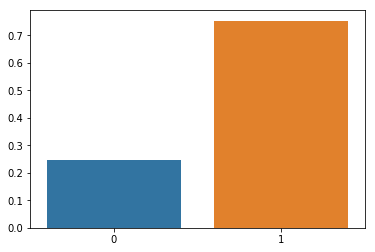

In [13]:
sns.barplot(x = lab, y = lab, estimator=lambda x: len(x)/len(lab))
plt.show()

## Modeling 

In [19]:
gru = nn.GRU(100, 67)
fc1 = nn.Linear(67, 1)
fc2 = nn.Linear(200, 1)
final = nn.Sigmoid()

In [14]:
# need to add original index so we can resort in case of packing
class CorpusData(Dataset):
    
    def __init__(self, data=None, labels=None, lens=None, test_size=0.25):
        #super().__init__()
        self.corpus = data
        self.labels = labels
        self.test_size = test_size
        self.lens = lens
        self.tr_idx, self.test_idx = None, None
        
    def __len__(self):
        return self.corpus.__len__()
    
    def __getitem__(self, i):
        return self.corpus[i], self.labels[i], self.lens[i]
    
    @staticmethod
    def idx_split(corpus):
        return train_test_split(range(len(corpus)))
    
    @classmethod
    def split_validation(cls, corpus):
        
        tr_idx, val_idx = train_test_split(range(len(corpus)))
        return cls(corpus[tr_idx]), cls(corpus[val_idx])

In [15]:
def get_batches(x, y, bsize):
    
    count = int(len(y)/bsize)+1
    def convert(lsls):
        return torch.stack([torch.tensor(ls) for ls in lsls])
    for i in range(count):
        a,b,c = len(y[i*bsize:(i+1)*bsize]), x[i*bsize:(i+1)*bsize], y[i*bsize:(i+1)*bsize]
        yield a, convert(b), torch.tensor(c) 
        


In [113]:
lens, idx = lens.sort(0, descending=True)

In [16]:
def prep_data(sents, targets, stack=False, pad = False, pack = False, sort=False):
    
    res =[(i, line, targets[i], len(line)) for i, line in enumerate(sents)]
    res = filter(lambda x:x[3] > 0, res)
    if sort:
        res = sorted(res, key=itemgetter(3), reverse=True)
    
    idx, seqs, labels, seq_lens =[], [], [], []

    for item in res:
    
        idx.append(item[0]), seqs.append(item[1]), labels.append(item[2]), seq_lens.append(item[3])
    
    if pad:
        # note that zip longest transposes the matrix
        padded=list(zip_longest(*seqs, fillvalue=0))
        # transpose
        seqs=list(zip_longest(*padded))
    
    if pack:
        # assumes no padding
        seqs= rnn.pack_sequence(seqs) 
    
    if stack:
        seqs=torch.stack(seqs).long()
        
    return idx, seqs, labels, torch.tensor(seq_lens)


In [174]:
class RNN(nn.Module):
    
    def __init__(self, emb_weights, batch_size, input_len):
        super().__init__()
        # vocab size in, hidden size out
        self.batch_size = batch_size
        self.embed_layer = nn.Embedding(emb_weights.shape[0], emb_weights.shape[1])
        self.emb_weights = emb_weights
        # input of shape (seq_len, batch, input_size) https://pytorch.org/docs/stable/nn.html
        self.lstm = nn.LSTM(input_len, input_len)
        """Input: (N, *, \text{in\_features})(N,∗,in_features) where *∗ means any number of additional dimensions
Output: (N, *, \text{out\_features})(N,∗,out_features) where all but the last dimension are the same shape as the input."""
        self.fc1 = nn.Linear(input_len,1)
        self.fc2 = nn.Linear(emb_weights.shape[1], 1)
        

    def load_weights(self):
        self.embed_layer.load_state_dict({'weight': self.emb_weights})
        return self
    
    def forward(self, inputs, input_lengths=None):
        
        
        embeds = self.embed_layer(inputs)
        #print(embeds.shape)
        unpacked, (hidden, cell) = self.lstm(embeds.permute(0,2,1))
        #print(unpacked.shape)
        

   
        out = self.fc1(unpacked)
        #print('out', out.shape)
        
        fout = self.fc2(out.view(1,-1,100))
        #print(fout.shape)
        prob = torch.sigmoid(fout)
        
        return prob.view(-1) 
    

class RNNpacked(nn.Module):
    
    def __init__(self, emb_weights, batch_size, input_len):
        super().__init__()
        # vocab size in, hidden size out
        self.batch_size = batch_size
        self.embed_layer = nn.Embedding(emb_weights.shape[0], emb_weights.shape[1])
        self.emb_weights = emb_weights
        # input of shape (seq_len, batch, input_size) https://pytorch.org/docs/stable/nn.html
        self.lstm = nn.LSTM(emb_weights.shape[1], emb_weights.shape[1])
        
        """Input: (N, *, \text{in\_features})(N,∗,in_features) where *∗ means any number of additional 
        dimensions Output: (N, *, \text{out\_features})(N,∗,out_features) where all but the last dimension 
        are the same shape as the input."""
        self.fc1 = nn.Linear(emb_weights.shape[1], 1)
        self.fc2 = nn.Linear(input_len,1)
        
        

    def load_weights(self):
        self.embed_layer.load_state_dict({'weight': self.emb_weights})
        return self
    
    def forward(self, inputs, input_lengths=None, verbose=False):
        if verbose:
            print('inputs', inputs.shape)
        embeds = self.embed_layer(inputs)
        if verbose:
            print('embeds', embeds.shape)
        
        packed = rnn.pack_padded_sequence(embeds, input_lengths, batch_first=True)
        if verbose:
            print('packed', packed[0].shape)
        out, (hidden, cell) = self.lstm(packed)
        unpacked, lengths = rnn.pad_packed_sequence(out, total_length=200, batch_first=True)
        if verbose:
            print('unpacked', unpacked.shape)
        out = self.fc1(unpacked)
        if verbose:
            print('out', out.shape)
        
        fout = self.fc2(out.permute(2,1,0))
        if verbose:
            print('fout', fout.shape)
        prob = torch.sigmoid(fout)
        
        return prob.view(-1)

In [83]:
traincls = CorpusData(data=train, labels=train_y, lens=train_lens)
train_loader = DataLoader(traincls, batch_size=10)

In [146]:
trainiter = iter(train_loader)

def sort_lens(x, y, lens):
    x=torch.stack(x,dim=1)
    lens_, indices = lens.sort(descending=True)
    x_, y_ = x[indices], y[indices]
    return x_, y_, lens_

#idx, x_, y_, _ = prep_data(x, y, stack=True, sort=True)

In [84]:
def test_next(trainiter):
    x, y, lens = next(trainiter)
    return sort_lens(x,y,lens)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [479]:
item = next(trainiter)
res = list(item[2].sort(descending=True))
a, b = filter(lambda x:x[0]>0, res)

In [91]:
traincls[0][2]

40

In [98]:
len([item for item in traincls[5][0] if item !=0]), traincls[5][2]

(23, 23)

In [105]:
len([item for item in x_[0] if item !=0]), lens_[0]

(99, tensor(172))

In [116]:
x,y, lens = next(trainiter)

In [130]:
len([item for item in torch.stack(x, dim=1)[3] if item != 0])

144

In [135]:
x_=torch.stack(x, dim=1)

In [137]:
torch.stack(x, dim=1)

tensor([[  197,   167, 13001,  ...,     0,     0,     0],
        [  172, 13001, 12725,  ...,     0,     0,     0],
        [13001, 13001,   153,  ...,     0,     0,     0],
        ...,
        [ 1001,   538,    50,  ...,     0,     0,     0],
        [11751, 13001,  1538,  ...,     0,     0,     0],
        [  656, 11144, 13001,  ...,     0,     0,     0]])

In [140]:
x_=x_[indices]

56

tensor(56)

In [139]:
lens_, indices = lens.sort(descending=True)

In [189]:
x_, y_, lens_ = test_next(trainiter)
len([item for item in x_[5] if item != 0]), lens_[5], y_[5]

model_packed(x_.cuda(), lens_, verbose=True)

inputs torch.Size([10, 200])
embeds torch.Size([10, 200, 100])
packed torch.Size([892, 100])
unpacked torch.Size([10, 200, 100])
out torch.Size([10, 200, 1])


RuntimeError: size mismatch, m1: [200 x 10], m2: [200 x 1] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:266

In [103]:
x_[0]

tensor([  156,   693,   388,   167,   314,  1428,  4786, 13001,  1037, 13001,
         2078, 13001,  2731,   160, 13001,   430, 13001,  4543, 13001,  1506,
          383,  1509, 13001,   255,     4,   288,   378, 13001, 13001,   257,
          884,  4156, 13001, 13001,  3146,   182,   117, 13001,   231, 12610,
        13001,   231,  2663,   985,    10,  4786,   167,   670,   433,  1069,
        13001,   211, 13001,   748,    86,   797,   101, 13001,  1320, 13001,
         1674, 13001,    39, 13001,   180,   801,    31, 13001,  2429,  1156,
        13001,  3120,    85,   518,   576, 13001,   442, 13001,   594, 13001,
        13001,   107, 13001,    99,   817,    66, 13001,   801, 13001,  3110,
            4, 13001, 13001,   430,  1158,   629, 13001, 13001,   716,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [187]:
# see https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
# import pdb; pdb.set_trace()

batch_size = 100
use='cpu'
input_len = 200
emb_t = torch.from_numpy(embedding_matrix)
emb = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
emb.load_state_dict({'weight': emb_t})
# model = RNN(emb_weights=emb_t, batch_size=batch_size, input_len=input_len)
# model.load_weights()
# model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model_packed = RNNpacked(emb_weights=emb_t, batch_size=batch_size, input_len=input_len)
model_packed.load_weights()
model_packed.to(device)



def fit(model, loss_function, opitmizer, dataclass, batch_size, epochs, device, packed=False):
    
    
    model.train()
    
    epoch_count = 0
    losses = []
    train_loader = DataLoader(dataclass, batch_size=batch_size)

    def train_epoch():
        i=0
        for j, (sent, target, lens) in enumerate(train_loader):
            optimizer.zero_grad()
            
            if packed:
                seqs, labels, lens_ = sort_lens(sent, target, lens)
                
                #log_probs = model(seqs.to(device), torch.tensor([100]*len(idx)).to(device))
                log_probs = model(seqs.to(device), lens_.to(device))
            else:    
                sent, labels = torch.stack(sent, dim=1).long().to(device), target.float().to(device)
                log_probs = model(sent)
            
            loss = loss_function(log_probs, labels.float().to(device))
            
            # gets graident
            loss.backward()
            # updates with new gradient
            optimizer.step()
            i += len(target)
            losses.append(loss.item())
            if i % 10000 == 0:
                print(f'{i/len(dataclass):.2f} of rows completed, current loss at {np.mean(losses[-30:]):.4f}')

#     model.train()
#     epoch_count = 0
#     losses = []
    
#     def train_epoch():
#         i=0
#         batch_gen = get_batches(train, train_y, bsize=batch_size)
#         for _, (j, sent, target) in enumerate(batch_gen):
#             optimizer.zero_grad()
#             #sent, target = sent.to(device), target.to(device)
#             sent, target = sent.long().to(device), target.float().to(device)
#             #idx, seqs, labels, lens = prep_data(sent, target, stack=True)
#             sent = sent.permute(1,0).contiguous()
#             #seqs=seqs.permute(1,0).contiguous()
#             #print(seqs.shape)
#             #seqs, labels = seqs.to(device), labels.float().to(device)
#             #log_probs = model(seqs, lens)
#             log_probs = model(sent)
#             loss = loss_function(log_probs, target)
#             # gets graident
#             loss.backward()
#             # updates with new gradient
#             optimizer.step()
#             i += len(target)
#             losses.append(loss.item())
#             if i % 100000 == 0:
#                 print(f'{i/len(train):.2f} of rows completed, current loss at {np.mean(losses[-30:]):.4f}')
    
#     print('training started...')

    for epoch in range(epochs):
    
        train_epoch()
        
        epoch_count += 1
        print(f'epoch {epoch_count} complete')
    
    return model, losses

In [35]:
x,y,z=next(iter(traincls))

In [188]:
#import pdb; pdb.set_trace()
model, losses = fit(model_packed, loss_function, optimizer, traincls, batch_size, 2, device=device, packed=True)

RuntimeError: size mismatch, m1: [200 x 100], m2: [200 x 1] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:266

In [494]:
np.mean(losses[-30:])

NameError: name 'losses' is not defined

In [94]:
%%time
valcls = CorpusData(data=val, labels=val_y)
val_loader = DataLoader(valcls, batch_size=250)

preds = []
with torch.no_grad():
   
    model.eval()
    for sent, target in val_loader:
        sent = sent.long().cuda()
        #print(sent.size())
        res = model(sent)
        preds.append(res)

print(loss_function(torch.cat(preds), torch.tensor(val_y).float().cuda()))    


tensor(0.1625, device='cuda:0')
CPU times: user 2.05 s, sys: 267 ms, total: 2.32 s
Wall time: 2.32 s


In [99]:
res = torch.cat(preds).cpu().numpy()

In [120]:
for i in range(20):
    cutoff = (1+i) * .05
    print(f'cutoff of {round(cutoff,3)} : ', round(classify(val_y, res, cutoff)['combined'],4))

cutoff of 0.05 :  0.8839
cutoff of 0.1 :  0.9002
cutoff of 0.15 :  0.9087
cutoff of 0.2 :  0.9138
cutoff of 0.25 :  0.9169
cutoff of 0.3 :  0.9189
cutoff of 0.35 :  0.92
cutoff of 0.4 :  0.9199
cutoff of 0.45 :  0.919
cutoff of 0.5 :  0.9177
cutoff of 0.55 :  0.9157
cutoff of 0.6 :  0.9126
cutoff of 0.65 :  0.908
cutoff of 0.7 :  0.902
cutoff of 0.75 :  0.8952
cutoff of 0.8 :  0.8842
cutoff of 0.85 :  0.868
cutoff of 0.9 :  0.8429
cutoff of 0.95 :  0.7892
cutoff of 1.0 :  nan


/home/ryeyoo/miniconda3/envs/torchdl/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


In [117]:
def classify(true, preds, cutoff):
    res = np.greater(preds, np.array(cutoff))
    recall = np.sum(res*true) / np.sum(true)
    precision = np.sum(res*true) / np.sum(res)
    return {'accuracy':np.mean(np.equal(true, res)), 'precision':precision, 'recall':recall, 'combined':precision*recall}
        

In [32]:
def evaluate(val, val_y, regression = False):
    
        
    preds = model.predict(val)
    #idx = np.random.randint(0, len(val_y), 5000)
    pred_err = np.subtract(val_y.astype('float32'), preds.reshape(-1))
    sns.distplot(pred_err)
    plt.show()
   
    if regression:
        rmse = np.sqrt(np.mean(pred_err**2))
        print('rmse : %.4f' % rmse)
    else:
        cond_error = round((abs(pred_err) >= 0.5).sum()/len(pred_err), 4)
        binary_cross_entropy = np.mean(
                                        val_y * np.log(preds.reshape(-1)) + \
                                       (1-val_y) * np.log(1-preds.reshape(-1))
        ) 
    
        print('prob error is greater than 0.5 is %.4f' % cond_error)
        print('binary cross entropy is %.4f' % binary_cross_entropy)
    

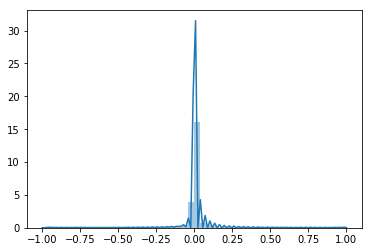

prob error is greater than 0.5 is 0.0497
binary cross entropy is -0.1304


In [33]:
evaluate(val, val_y)